In [1]:
import torch
import torch.nn as nn
import torch.utils.data as data
import torchmetrics
import torchvision as tv

import lightning as L
import matplotlib.pyplot as plt
import numpy as np

print("Using torch", torch.__version__)
print("Using lightning", L.__version__)

Using torch 2.4.1+cpu
Using lightning 2.4.0


Number of training samples: 55000
Number of validation samples: 4000
Number of test samples: 1000
Shape of image: torch.Size([1, 28, 28])
Label for this image: 3


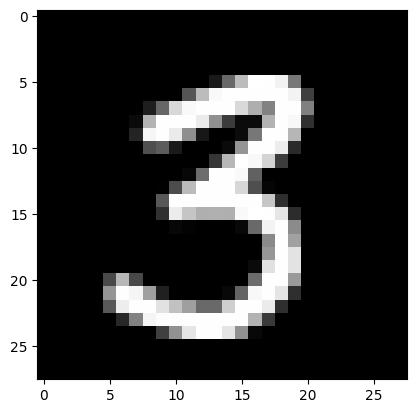

In [2]:
# --------------------
# Load Dataset - MNIST
# --------------------

# dataset: tuple[tensor of shape (N, R, C), label: int]
dataset = tv.datasets.MNIST(root=".", download=True, transform=tv.transforms.ToTensor())
train, val, test = data.random_split(dataset, [55000, 4000, 1000], torch.Generator().manual_seed(42))

# visualize
n = 44
image, label = train[n]
print(f"Number of training samples: {len(train)}")
print(f"Number of validation samples: {len(val)}")
print(f"Number of test samples: {len(test)}")
print(f"Shape of image: {image.shape}")
print(f"Label for this image: {label}")
plt.imshow(image.squeeze(), cmap="gray")

In [3]:
from IPython.display import Image
Image(url="https://www.gabormelli.com/RKB/images/1/19/2NNw.png")

In [4]:
# ------------
# Create Model
# ------------
class HelloModel(L.LightningModule):
    def __init__(self, hidden_nodes: int = 64):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(in_features=28 * 28, out_features=hidden_nodes),
            nn.ReLU(),
            nn.Linear(in_features=hidden_nodes, out_features=10),
        )
        self.train_accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=10)
        self.val_accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=10)

    def forward(self, x):
        return self.encoder(x)

    def training_step(self, batch):
        loss = self._step(batch, "train")
        return loss

    def validation_step(self, batch):
        loss = self._step(batch, "val")
        return loss

    def _step(self, batch, step_type):
        images, labels = batch  # images: NxRxC
        n_batch = len(images)
        images = images.view(n_batch, -1)  # images: N x (RxC)
        
        # make predictions
        predictions = self.encoder(images)
        
        loss_fn = nn.CrossEntropyLoss()
        loss = loss_fn(predictions, labels)
        self.log(f"{step_type}_loss", loss)
        
        if step_type == "train":
            self.train_accuracy(predictions, labels)
            self.log(f"{step_type}_accuracy", self.train_accuracy)
        else:
            self.val_accuracy(predictions, labels)
            self.log(f"{step_type}_accuracy", self.val_accuracy)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.001)
        return optimizer

In [5]:
# -----------
# Train Model
# -----------
model = HelloModel(hidden_nodes=64)

train_dataloader = data.DataLoader(
    dataset=train,
    batch_size=32,
    shuffle=True,
    num_workers=8,
    pin_memory=True,
    persistent_workers=True,
)
val_dataloader = data.DataLoader(
    dataset=val,
    batch_size=64,
    shuffle=False,
    num_workers=8,
    pin_memory=True,
    persistent_workers=True,
)
trainer = L.Trainer(max_epochs=5)
trainer.fit(
    model=model,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name           | Type               | Params | Mode 
--------------------------------------------------------------
0 | encoder        | Sequential         | 50.9 K | train
1 | train_accuracy | MulticlassAccuracy | 0      | train
2 | val_accuracy   | MulticlassAccuracy | 0      | train
--------------------------------------------------------------
50.9 K    Trainable params
0         Non-trainable params
50.9 K    Total params
0.204     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


6
tensor([[ -3.8477,  -7.5925,  -0.7724,  -3.7949,  -3.6642,  -0.5398,  11.4356,
         -13.8284,  -5.6586, -11.3882]], grad_fn=<AddmmBackward0>)


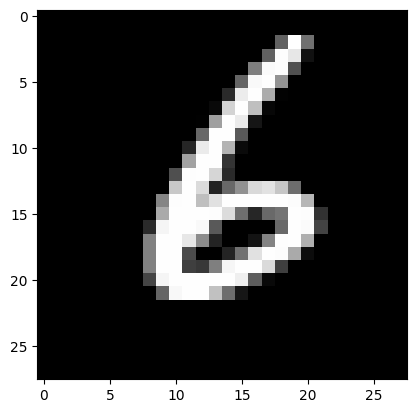

In [6]:
# -------------
# Run Inference
# -------------
n = 53
image, label = test[n]
plt.imshow(image.squeeze(), cmap="gray")
image = image.view(1, -1)
pred = model.encoder(image)
print(label)
print(pred)

In [ ]:
# tensorboard --logdir .